In [1]:
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from scipy import stats
import itertools

D:\python\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# 读取CSV文件
df_spy_data = pd.read_csv('spy_data.csv')
df_spy_data.head()

,Unnamed: 0,log_ret,rv5,bv
0,2000-01-04,-0.038711,0.000224,0.000173
1,2000-01-05,0.002192,0.000314,0.000303
2,2000-01-06,0.000692,0.000131,0.000128
3,2000-01-07,0.026571,0.000094,0.000079
4,2000-01-10,0.011043,0.000120,0.000136


In [3]:
# 在分割数据前进行特征处理
def transform_features(df):
    """
    对特征进行变换：包含移动平均计算
    """
    df_transformed = df.copy()
    
    # 1. 基础变换
    df_transformed['rv5_sqrt'] = np.sqrt(df_transformed['rv5'])
    df_transformed['bv_sqrt'] = np.sqrt(df_transformed['bv'])
    diff = df_transformed['rv5'] - df_transformed['bv']
    df_transformed['rv5-bv_sqrt'] = np.sqrt(np.maximum(diff, 0))
    
    
    # 2. 删除原始列和中间列
    df_transformed = df_transformed.drop(['rv5', 'bv'], axis=1)
    
    # 3. 重排列顺序
    df_transformed = df_transformed[['Unnamed: 0', 'log_ret', 
                                     'rv5_sqrt', 'bv_sqrt', 'rv5-bv_sqrt']]
    
    return df_transformed

In [4]:
# 应用特征变换
df_spy_data = transform_features(df_spy_data)
df_spy_data.head()

,Unnamed: 0,log_ret,rv5_sqrt,bv_sqrt,rv5-bv_sqrt
0,2000-01-04,-0.038711,0.014971,0.013165,0.007128
1,2000-01-05,0.002192,0.017728,0.017400,0.003397
2,2000-01-06,0.000692,0.011437,0.011333,0.001538
3,2000-01-07,0.026571,0.009676,0.008872,0.003862
4,2000-01-10,0.011043,0.010964,0.011651,0.000000


In [5]:
#按时间顺序对训练集测试集进行分割
train_size = int(len(df_spy_data) * 0.6)
validation_size = int(len(df_spy_data) * 0.2)
test_size = len(df_spy_data) - train_size - validation_size

validation_end = train_size + validation_size

train, validation, test = df_spy_data[:train_size], df_spy_data[train_size:validation_end], df_spy_data[validation_end:]

In [6]:
def create_multivariate_dataset(dataset, window_size):
    """
    将时间序列进行滑窗
    
    参数:
        dataset: DataFrame，其中包含特征和标签，特征从索引1开始，第一列是标签
        window_size: 滑窗的窗口大小
    """
    X, y = [], []
    for i in range(len(dataset) - window_size):
        # 选取从第2列到最后一列的特征和标签
        feature_and_label = dataset.iloc[i:i + window_size, 1:].values  # 包括标签在内的特征
        # 下一个时间点的标签作为目标
        target = dataset.iloc[i + window_size, 1]  # 使用下一个时间点的标签作为预测目标
        X.append(feature_and_label)
        y.append(target)
    # 转换为numpy数组，适合TensorFlow输入
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    
    return X, y

In [7]:
X_train, y_train = create_multivariate_dataset(train, 21)
X_validation, y_validation = create_multivariate_dataset(validation, 21)
X_test, y_test = create_multivariate_dataset(test, 21)

In [8]:
y_train_reshaped = y_train.reshape(-1, 1)
y_train = y_train_reshaped

In [9]:
# 定义分位数损失函数
class QuantileLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.05, name="quantile_loss"):
        super().__init__(name=name)
        self.alpha = alpha
    
    def call(self, y_true, y_pred):
        errors = y_true - y_pred
        return tf.reduce_mean(
            tf.maximum((self.alpha - 1) * errors, self.alpha * errors)
        )
    
    def get_config(self):
        config = super().get_config()
        config.update({"alpha": self.alpha})
        return config

In [10]:
def create_model(units1=128, units2=32, learning_rate=0.001, alpha=0.05):
    """创建可配置的神经网络模型（无正则化/无Dropout）"""
    model = Sequential([
        tf.keras.layers.Input(shape=(21, 4)), #步长，特征数量
        tf.keras.layers.Flatten(),  # 展平
        tf.keras.layers.Dense(units=units1),
        tf.keras.layers.LeakyReLU(negative_slope=0.2),
        tf.keras.layers.Dense(units=units2),
        tf.keras.layers.LeakyReLU(negative_slope=0.2),
        tf.keras.layers.Dense(units=1, activation='linear'),
    ])
    
    quantile_loss_fn = QuantileLoss(alpha=alpha)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=quantile_loss_fn
    )
    
    return model

In [11]:
class EarlyStopping(Callback):
    """自定义早停回调，早停后保持当前权重"""
    def __init__(self, monitor='val_loss',  patience=3, restore_best_weights=True, verbose=0):
        super().__init__()
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.verbose = verbose
        self.best_value = float('inf')
        self.wait = 0
        
    def on_train_begin(self, logs=None):
        self.wait = 0
        self.best_value = float('inf')
        
    def on_epoch_end(self, epoch, logs=None):
        current_value = logs.get(self.monitor)
        if current_value is None:
            return
            
        # 每10个epoch检查一次
        if (epoch + 1) % 5 == 0:
            if current_value < self.best_value:
                self.best_value = current_value
                self.wait = 0
                if self.verbose > 0:
                    print(f"Epoch {epoch+1}: {self.monitor} 改善到 {current_value:.6f}")
            else:
                self.wait += 1
                if self.verbose > 0:
                    print(f"Epoch {epoch+1}: {self.monitor} = {current_value:.6f}, 没有改善，等待计数: {self.wait}/{self.patience}")
                
            # 检查是否需要停止训练
            if self.wait >= self.patience:
                self.model.stop_training = True
                if self.verbose > 0:
                    print(f"Epoch {epoch+1}: 早停触发。保持当前权重。")

In [12]:
def train_with_params(params, X_train, y_train, X_val, y_val, alpha=0.05):
    """使用给定参数训练模型并返回训练历史"""
    units1 = params['units1']
    units2 = params['units2']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    
    # 创建模型
    model = create_model(units1=units1, units2=units2, 
                         learning_rate=learning_rate, alpha=alpha)
    
    # 定义回调
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,  # 虽然设置为True，但回调为不恢复最佳权重
        verbose=0  # 安静模式
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=0
    )
    
    # 训练模型
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    # 获取最佳验证损失
    best_val_loss = min(history.history['val_loss'])
    
    return best_val_loss, model, history

In [13]:
def hyperparameter_tuning(param_grid, X_train, y_train, X_val, y_val, alpha=0.05):
    """执行超参数网格搜索"""
    print(f"=== 开始超参数网格搜索（alpha={alpha}） ===")
    print(f"参数网格: {param_grid}")
    
    keys = param_grid.keys()
    values = param_grid.values()
    param_combinations = [dict(zip(keys, combination)) 
                          for combination in itertools.product(*values)]
    
    total_combinations = len(param_combinations)
    print(f"总参数组合数: {total_combinations}")
    
    best_val_loss = float('inf')
    best_params = None
    best_model = None
    best_history = None
    
    for i, params in enumerate(param_combinations):
        
        # 训练模型
        val_loss, model, history = train_with_params(params, X_train, y_train, X_val, y_val, alpha=alpha)
        
        # 更新最佳结果
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params
            best_model = model
            best_history = history
    
    print(f"\n=== 网格搜索完成（alpha={alpha}） ===")
    print(f"最佳参数: {best_params}")
    print(f"最佳验证损失: {best_val_loss:.6f}")
    
    return best_params, best_model, best_val_loss, best_history


In [14]:
# 定义多个 alpha 值
alphas = [0.01, 0.05, 0.1]

# 定义参数网格
param_grid = {
    'units1': [128, 256],
    'units2': [16, 32, 64],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [16, 32]
}

# 存储每个 alpha 的最佳模型和参数
best_models = {}
best_params_dict = {}
best_val_losses = {}
best_histories = {}  # 存储训练历史

# 对每个 alpha 执行超参数调优
for alpha in alphas:
    print(f"\n{'='*60}")
    print(f"开始训练 alpha={alpha} 的模型")
    print(f"{'='*60}")
    
    best_params, best_model, best_val_loss, best_history = hyperparameter_tuning(
        param_grid, X_train, y_train, X_validation, y_validation, alpha=alpha
    )
    
    best_models[alpha] = best_model
    best_params_dict[alpha] = best_params
    best_val_losses[alpha] = best_val_loss
    best_histories[alpha] = best_history  # 存储训练历史


开始训练 alpha=0.01 的模型
=== 开始超参数网格搜索（alpha=0.01） ===
参数网格: {'units1': [128, 256], 'units2': [16, 32, 64], 'learning_rate': [0.001, 0.0005], 'batch_size': [16, 32]}
总参数组合数: 24

=== 网格搜索完成（alpha=0.01） ===
最佳参数: {'units1': 128, 'units2': 16, 'learning_rate': 0.0005, 'batch_size': 16}
最佳验证损失: 0.000277

开始训练 alpha=0.05 的模型
=== 开始超参数网格搜索（alpha=0.05） ===
参数网格: {'units1': [128, 256], 'units2': [16, 32, 64], 'learning_rate': [0.001, 0.0005], 'batch_size': [16, 32]}
总参数组合数: 24

=== 网格搜索完成（alpha=0.05） ===
最佳参数: {'units1': 256, 'units2': 32, 'learning_rate': 0.001, 'batch_size': 16}
最佳验证损失: 0.001021

开始训练 alpha=0.1 的模型
=== 开始超参数网格搜索（alpha=0.1） ===
参数网格: {'units1': [128, 256], 'units2': [16, 32, 64], 'learning_rate': [0.001, 0.0005], 'batch_size': [16, 32]}
总参数组合数: 24

=== 网格搜索完成（alpha=0.1） ===
最佳参数: {'units1': 256, 'units2': 64, 'learning_rate': 0.0005, 'batch_size': 16}
最佳验证损失: 0.001675


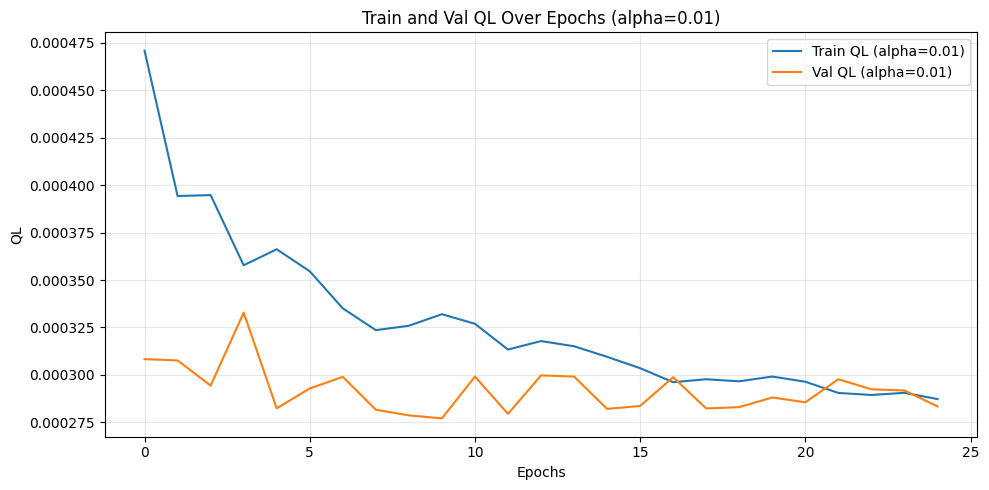

alpha=0.01: 最终训练损失 = 0.000287, 最终验证损失 = 0.000283


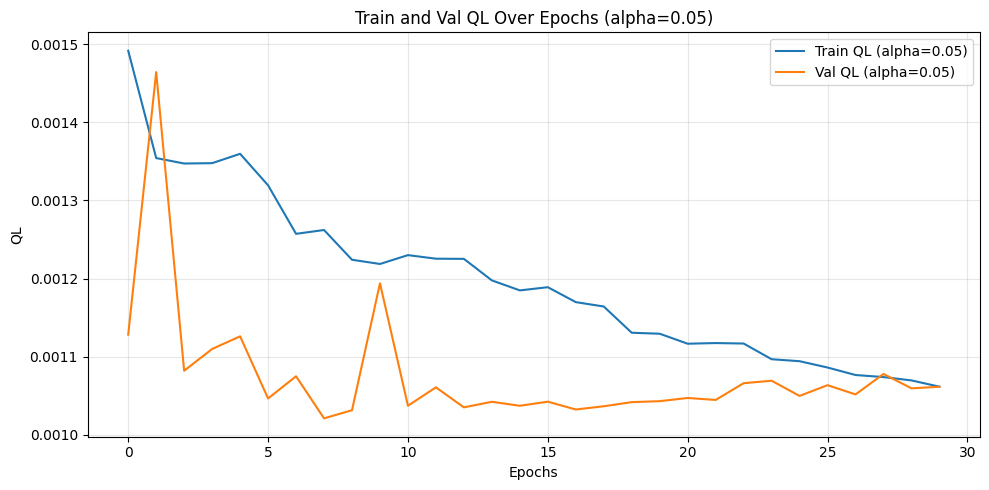

alpha=0.05: 最终训练损失 = 0.001062, 最终验证损失 = 0.001062


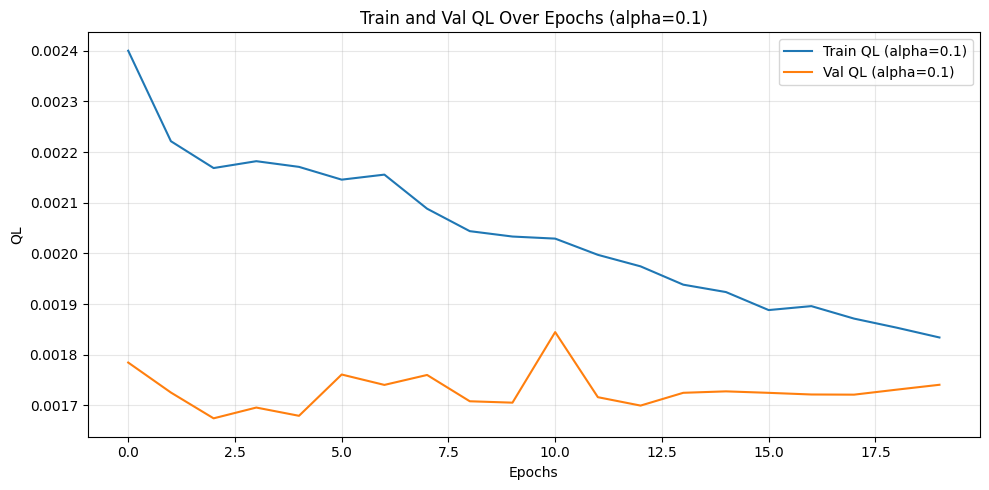

alpha=0.1: 最终训练损失 = 0.001834, 最终验证损失 = 0.001741


In [15]:
# 绘制每个 alpha 的训练和验证损失曲线
for alpha in alphas:
    history = best_histories[alpha]
    
    # 提取训练损失和验证损失
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label=f'Train QL (alpha={alpha})')
    plt.plot(val_losses, label=f'Val QL (alpha={alpha})')
    plt.xlabel('Epochs')
    plt.ylabel('QL')
    plt.title(f'Train and Val QL Over Epochs (alpha={alpha})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 打印最终损失值
    print(f"alpha={alpha}: 最终训练损失 = {train_losses[-1]:.6f}, 最终验证损失 = {val_losses[-1]:.6f}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


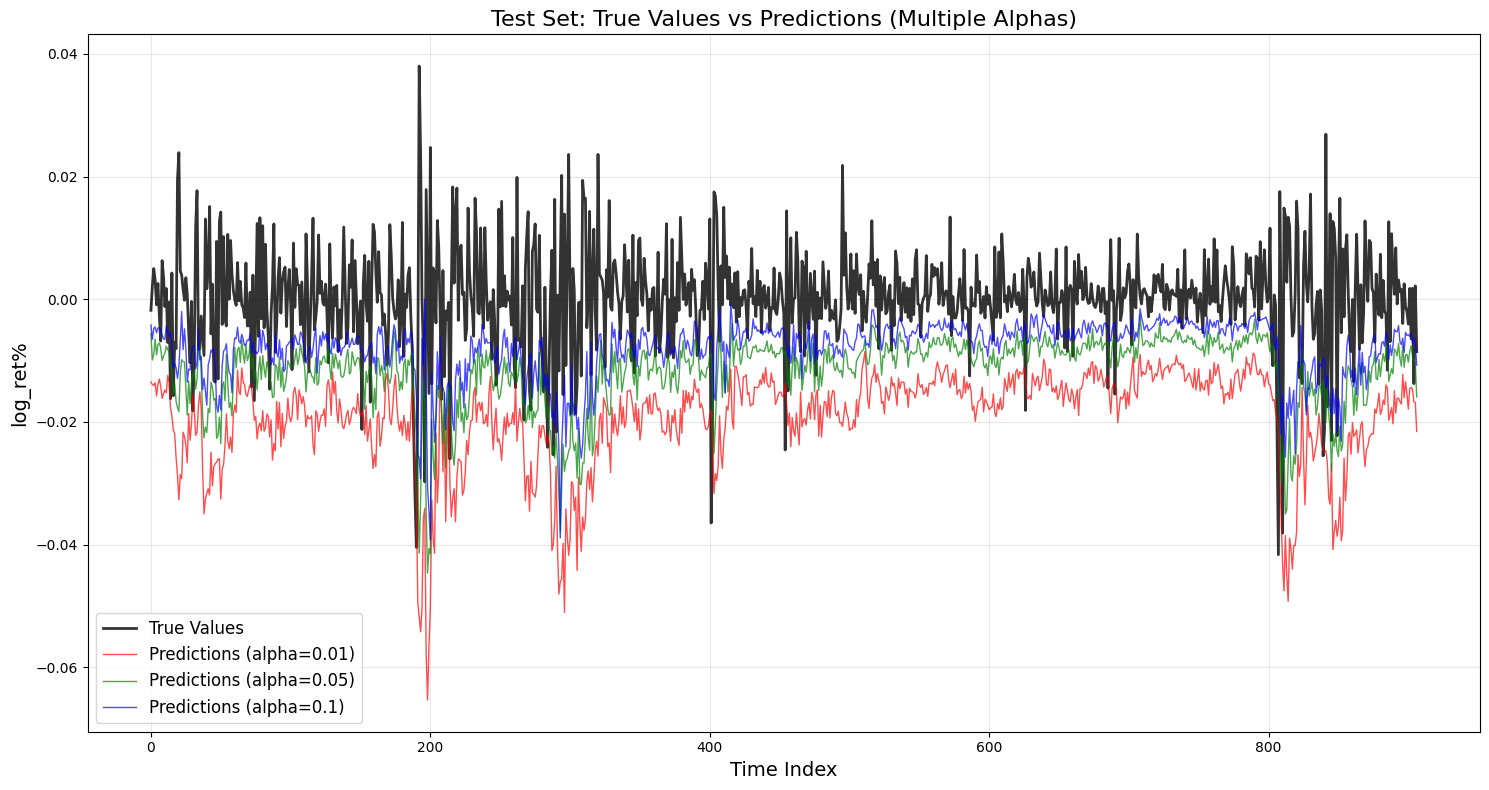

In [16]:
# 对每个 alpha 的模型进行预测
predictions_train = {}
predictions_validation = {}
predictions_test = {}
for alpha in alphas:
    predictions_train[alpha] = best_models[alpha].predict(X_train)
    predictions_validation[alpha] = best_models[alpha].predict(X_validation)
    predictions_test[alpha] = best_models[alpha].predict(X_test)

# 绘制多个 alpha 的预测结果对比图
plt.figure(figsize=(15, 8))
time_indices = np.arange(len(y_test))

plt.plot(time_indices, y_test, 'k-', label='True Values', linewidth=2, alpha=0.8)

colors = ['r', 'g', 'b']
for idx, alpha in enumerate(alphas):
    plt.plot(time_indices, predictions_test[alpha], 
             label=f'Predictions (alpha={alpha})', 
             color=colors[idx], alpha=0.7, linewidth=1)

plt.title('Test Set: True Values vs Predictions (Multiple Alphas)', fontsize=16)
plt.xlabel('Time Index', fontsize=14)
plt.ylabel('log_ret%', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
import numpy as np
import statsmodels.api as sm

def dq_test_with_pvalue(y, q_pred, tau, lags=4):
    """返回DQ检验的统计量和P值"""
    # 确保y是一维数组
    y = np.array(y).flatten()
    
    # 确保q_pred是一维数组（如果是二维的(2763,1)就展平）
    q_pred = np.array(q_pred).flatten()
    
    # 检查长度是否匹配
    if len(y) != len(q_pred):
        raise ValueError(f"y和q_pred长度不匹配: y={len(y)}, q_pred={len(q_pred)}")
    
    # 计算hit序列
    hit = (y <= q_pred).astype(float)
    
    # 检查hit序列是否全是0或1（避免退化情况）
    if np.all(hit == 0) or np.all(hit == 1):
        print("警告: hit序列全是0或1，DQ检验可能不准确")
        return np.nan, np.nan
    
    # 构建回归矩阵：包含截距项和滞后项
    n = len(hit)
    X = np.ones((n - lags, lags + 1))
    # 填充滞后项
    for i in range(lags):
        X[:, i + 1] = hit[i:-(lags - i)]
    
    # 因变量：hit序列的滞后部分减去理论覆盖率
    y_dq = hit[lags:] - tau
    
    # 拟合回归模型
    model = sm.OLS(y_dq, X).fit()
    
    # 使用F检验检验除截距外的所有滞后项系数是否为0
    # 构建约束矩阵：检验第2到第(lags+1)个系数是否为0
    R = np.zeros((lags, lags + 1))
    for i in range(lags):
        R[i, i + 1] = 1  # 跳过截距项（第0个系数）
    
    # 执行Wald检验
    wald_result = model.wald_test(R)
    
    # 获取统计量和p值
    dq_statistic = wald_result.statistic[0][0]
    dq_pvalue = wald_result.pvalue

    return dq_statistic, dq_pvalue

In [18]:
# DQ 检验 - 验证集
print(f"\n{'='*60}")
print("DQ 检验结果 - 验证集")
print(f"{'='*60}")

for alpha in alphas:
    print(f"\nalpha={alpha}:")
    dq_stat, dq_p = dq_test_with_pvalue(
        y=y_validation, 
        q_pred=predictions_validation[alpha], 
        tau=alpha, 
        lags=4
    )
    
    print(f"DQ统计量: {dq_stat:.4f}")
    print(f"DQ检验P值: {dq_p:.4f}")
    
    if dq_p > 0.05:
        print(f"✅ alpha={alpha}: 验证集模型通过DQ检验（p值 > 0.05）")
    else:
        print(f"❌ alpha={alpha}: 验证集模型未通过DQ检验（p值 ≤ 0.05）")

        
# DQ 检验 - 测试集
print(f"\n{'='*60}")
print("DQ 检验结果 - 测试集")
print(f"{'='*60}")

for alpha in alphas:
    print(f"\nalpha={alpha}:")
    dq_stat, dq_p = dq_test_with_pvalue(
        y=y_test, 
        q_pred=predictions_test[alpha], 
        tau=alpha, 
        lags=4
    )
    
    print(f"DQ统计量: {dq_stat:.4f}")
    print(f"DQ检验P值: {dq_p:.4f}")
    
    if dq_p > 0.05:
        print(f"✅ alpha={alpha}: 测试集模型通过DQ检验（p值 > 0.05）")
    else:
        print(f"❌ alpha={alpha}: 测试集模型未通过DQ检验（p值 ≤ 0.05）")


DQ 检验结果 - 验证集

alpha=0.01:
DQ统计量: 0.9066
DQ检验P值: 0.4594
✅ alpha=0.01: 验证集模型通过DQ检验（p值 > 0.05）

alpha=0.05:
DQ统计量: 0.6619
DQ检验P值: 0.6186
✅ alpha=0.05: 验证集模型通过DQ检验（p值 > 0.05）

alpha=0.1:
DQ统计量: 0.2159
DQ检验P值: 0.9296
✅ alpha=0.1: 验证集模型通过DQ检验（p值 > 0.05）

DQ 检验结果 - 测试集

alpha=0.01:
DQ统计量: 8.3904
DQ检验P值: 0.0000
❌ alpha=0.01: 测试集模型未通过DQ检验（p值 ≤ 0.05）

alpha=0.05:
DQ统计量: 0.6097
DQ检验P值: 0.6558
✅ alpha=0.05: 测试集模型通过DQ检验（p值 > 0.05）

alpha=0.1:
DQ统计量: 0.7658
DQ检验P值: 0.5476
✅ alpha=0.1: 测试集模型通过DQ检验（p值 > 0.05）


D:\python\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [19]:
def kupiec_test_tensorflow(y_true, y_pred, confidence_level=0.05):
    """
    Kupiec失败率检验（LR统计量）
    
    参数说明：
    ----------
    y_true : tf.Tensor, np.array 或 Python列表
        真实值
        shape: (n_samples,)
    
    y_pred : tf.Tensor, np.array 或 Python列表
        VaR预测值
        shape: (n_samples,)
        
   confidence_level : float 
       预期失败率
    
    返回：
    -------
    dict: 包含检验结果的字典
        - 'n_samples': 总样本数
        - 'failures': 失败次数（实际收益率 < VaR）
        - 'expected_failures': 预期失败次数
        - 'failure_rate': 实际失败率
        - 'expected_rate': confidence_level
        - 'LR_statistic': LR统计量
        - 'p_value': p值
        - 'reject_null': 是否拒绝原假设（模型不准确）
    """
    
    # 确保为numpy数组
    if tf.is_tensor(y_true):
        y_true = y_true.numpy()
    if tf.is_tensor(y_pred):
        y_pred = y_pred.numpy()
    
    # 转换为numpy数组（如果已经是numpy数组则不变）
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()
    
    # 检查形状
    if y_true.shape != y_pred.shape:
        raise ValueError(f"形状不匹配: y_true={y_true.shape}, y_pred={y_pred.shape}")
    
    # 计算失败次数（实际收益率 < VaR预测值）
    failures = np.sum(y_true < y_pred)
    n_samples = len(y_true)
    
    # 计算失败率
    failure_rate = failures / n_samples
    expected_rate = confidence_level
    
    # 计算预期失败次数
    expected_failures = n_samples * expected_rate
    
    # 计算LR统计量（似然比检验）
    # 原假设：实际失败率 = 预期失败率
    if failures == 0:
        # LR = -2 * N * ln(1-p)
        LR = -2 * n_samples * np.log(1 - expected_rate)
    elif failures == n_samples:
        # LR = -2 * N * ln(p)
        LR = -2 * n_samples * np.log(expected_rate)
    else:
        # LR = -2 * [ln((1-p)^(N-x) * p^x) - ln((1-(x/N))^(N-x) * (x/N)^x)]
        p = expected_rate
        x = failures
        N = n_samples
        
        # 使用对数避免数值下溢
        term1 = (N - x) * np.log(1 - p) + x * np.log(p)
        term2 = (N - x) * np.log(1 - x/N) + x * np.log(x/N)
        
        LR = -2 * (term1 - term2)
    
    # 计算p值（自由度为1的卡方分布）
    p_value = 1 - stats.chi2.cdf(LR, df=1)
    
    # 判断结果（通常使用5%显著性水平）
    reject_null = p_value < 0.05
    
    # 返回结果字典
    return {
        'n_samples': n_samples,
        'failures': failures,
        'expected_failures': round(expected_failures, 2),
        'failure_rate': round(failure_rate, 4),
        'expected_rate': round(expected_rate, 4),
        'LR_statistic': round(LR, 4),
        'p_value': round(p_value, 4),
        'reject_null': reject_null,
        'conclusion': '模型拒绝' if reject_null else '模型接受'
    }

In [20]:
# Kupiec检验 - 验证集
print(f"\n{'='*60}")
print("Kupiec检验结果 - 验证集")
print(f"{'='*60}")

for alpha in alphas:
    print(f"\nalpha={alpha}:")
    result = kupiec_test_tensorflow(
        y_true=y_validation, 
        y_pred=predictions_validation[alpha], 
        confidence_level=alpha
    )
    
    print("检验结果:")
    for key, value in result.items():
        print(f"  {key}: {value}")
    print("-" * 30)

# Kupiec检验 - 测试集
print(f"\n{'='*60}")
print("Kupiec检验结果 - 测试集")
print(f"{'='*60}")

for alpha in alphas:
    print(f"\nalpha={alpha}:")
    result = kupiec_test_tensorflow(
        y_true=y_test, 
        y_pred=predictions_test[alpha], 
        confidence_level=alpha
    )
    
    print("检验结果:")
    for key, value in result.items():
        print(f"  {key}: {value}")
    print("-" * 30)


Kupiec检验结果 - 验证集

alpha=0.01:
检验结果:
  n_samples: 907
  failures: 14
  expected_failures: 9.07
  failure_rate: 0.0154
  expected_rate: 0.01
  LR_statistic: 2.3215
  p_value: 0.1276
  reject_null: False
  conclusion: 模型接受
------------------------------

alpha=0.05:
检验结果:
  n_samples: 907
  failures: 49
  expected_failures: 45.35
  failure_rate: 0.054
  expected_rate: 0.05
  LR_statistic: 0.3017
  p_value: 0.5828
  reject_null: False
  conclusion: 模型接受
------------------------------

alpha=0.1:
检验结果:
  n_samples: 907
  failures: 113
  expected_failures: 90.7
  failure_rate: 0.1246
  expected_rate: 0.1
  LR_statistic: 5.6965
  p_value: 0.017
  reject_null: True
  conclusion: 模型拒绝
------------------------------

Kupiec检验结果 - 测试集

alpha=0.01:
检验结果:
  n_samples: 907
  failures: 15
  expected_failures: 9.07
  failure_rate: 0.0165
  expected_rate: 0.01
  LR_statistic: 3.2716
  p_value: 0.0705
  reject_null: False
  conclusion: 模型接受
------------------------------

alpha=0.05:
检验结果:
  n_samples:

In [21]:
# 计算测试集平均损失
print(f"\n{'='*60}")
print("测试集平均损失值计算")
print(f"{'='*60}")

for alpha in alphas:
    errors = y_test - predictions_test[alpha].flatten()
    avg_loss = np.mean(np.maximum((alpha - 1) * errors, alpha * errors))    
    print(f"alpha={alpha}: 测试集平均损失 = {avg_loss:.6f}")


测试集平均损失值计算
alpha=0.01: 测试集平均损失 = 0.000289
alpha=0.05: 测试集平均损失 = 0.000946
alpha=0.1: 测试集平均损失 = 0.001529
